# 차선 인식하기
사용될 변수를 초기화합니다.

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from zumi.zumi import Zumi
from zumi.util.screen import Screen

YELLOW = LOW  = LEFT = FRACTION = 0
WHITE = HIGH = RIGHT = LANE     = 1
MOV_AVG_LENGTH = 5

WIDTH = 320
HEIGHT = 160
HALF_W = WIDTH // 2
HALF_H = HEIGHT // 2

FRACTION_LIMIT = 300

# DetectLane
차선을 인식하는 클래스입니다. hue, saturation, lightness로 이루어진 HSV 포맷의 이미지를 이용하여 각각 흰색, 노란색 영역을 추출한 뒤, 윈도우 단위로 탐색을 하여 추출된 영역의 방향성을 설정합니다. 흰색과 노란색의 중간 지점의 벡터값을 반환합니다.

In [22]:
class DetectLane:
    def __init__(self, debug=True):
        self.debug = debug
        
        self.hue = [[30, 50], [0, 255]]
        self.saturation = [[250, 255], [0, 255]]
        self.lightness = [[250, 255], [230, 255]]        
        self.reliability = [100, 100]
        
    def find_lane(self, cv_image):
        # Convert BGR to HSV
        self.hsv = cv2.cvtColor(cv_image, cv2.COLOR_RGB2HSV)
    
        # find White and Yellow Lanes
        mask = [
            self.mask_lane(self.hsv, YELLOW),
            self.mask_lane(self.hsv, WHITE)
        ]
        
        try:
            if mask[YELLOW][FRACTION] > FRACTION_LIMIT / 2:
                self.fitx[LEFT], self.fit[LEFT] = self.fit_from_lines(self.fit[LEFT], mask[YELLOW][LANE])
                self.mov_avg[LEFT] = np.append(self.mov_avg[LEFT], np.array([self.fit[LEFT]]), axis=0)
                
            if mask[WHITE][FRACTION] > FRACTION_LIMIT / 2:
                self.fitx[RIGHT], self.fit[RIGHT] = self.fit_from_lines(self.fit[RIGHT], mask[WHITE][LANE])
                self.mov_avg[RIGHT] = np.append(self.mov_avg[RIGHT], np.array([self.fit[RIGHT]]), axis=0)
                
        except:
            self.fit = [None, None]
            self.fitx = [None, None]
            self.mov_avg = [None, None]

            if mask[YELLOW][FRACTION] > FRACTION_LIMIT / 2 :
                self.fitx[LEFT], self.fit[LEFT] = self.sliding_windown(mask[YELLOW][LANE], LEFT)
                self.mov_avg[LEFT] = np.array([self.fit[LEFT]])
            
            if mask[WHITE][FRACTION] > FRACTION_LIMIT / 2:
                self.fitx[RIGHT], self.fit[RIGHT] = self.sliding_windown(mask[WHITE][LANE], RIGHT)
                self.mov_avg[RIGHT] = np.array([self.fit[RIGHT]])
                
        self.fit[LEFT] = np.array([np.mean(self.mov_avg[LEFT][::-1][:, 0][0:MOV_AVG_LENGTH]),
                            np.mean(self.mov_avg[LEFT][::-1][:, 1][0:MOV_AVG_LENGTH]),
                            np.mean(self.mov_avg[LEFT][::-1][:, 2][0:MOV_AVG_LENGTH])])
        self.fit[RIGHT] = np.array([np.mean(self.mov_avg[RIGHT][::-1][:, 0][0:MOV_AVG_LENGTH]),
                            np.mean(self.mov_avg[RIGHT][::-1][:, 1][0:MOV_AVG_LENGTH]),
                            np.mean(self.mov_avg[RIGHT][::-1][:, 2][0:MOV_AVG_LENGTH])])
        
        if self.mov_avg[LEFT].shape[0] > WIDTH:
            self.mov_avg[LEFT] = self.mov_avg[LEFT][0:MOV_AVG_LENGTH]

        if self.mov_avg[RIGHT].shape[0] > WIDTH:
            self.mov_avg[RIGHT] = self.mov_avg[RIGHT][0:MOV_AVG_LENGTH]

        return self.make_lane(cv_image, mask[YELLOW][FRACTION], mask[WHITE][FRACTION])

    def mask_lane(self, image, color):
        # define range of color in HSV
        lower_bound = np.array([
            self.hue[color][LOW],
            self.saturation[color][LOW],
            self.lightness[color][LOW]]
        )
        upper_bound = np.array([
            self.hue[color][HIGH],
            self.saturation[color][HIGH],
            self.lightness[color][HIGH]]
        )

        # Threshold the HSV image to get only white colors
        mask = cv2.inRange(image, lower_bound, upper_bound)
        fraction_num = np.count_nonzero(mask)
        print(color, fraction_num)
        
        if fraction_num > FRACTION_LIMIT * 5:
            if self.lightness[color][LOW] < 250:
                self.lightness[color][LOW] += 5
        elif fraction_num < FRACTION_LIMIT * 2:
            if self.lightness[color][LOW] > 50:
                self.lightness[color][LOW] -= 5

        how_much_short = HEIGHT
        for i in range(0, HEIGHT):
            if np.count_nonzero(mask[i,::]) > 0:
                how_much_short -= 1

        if how_much_short > 100:
            if self.reliability[color] >= 5:
                self.reliability[color] -= 5
        elif how_much_short <= 100:
            if self.reliability[color] <= 99:
                self.reliability[color] += 5

        camera.show_image(mask)
        return fraction_num, mask

    def fit_from_lines(self, lane_fit, image):
        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        lane_inds = ((nonzerox > (lane_fit[0] * (nonzeroy ** 2) + lane_fit[1] * nonzeroy + lane_fit[2] - margin)) & (
        nonzerox < (lane_fit[0] * (nonzeroy ** 2) + lane_fit[1] * nonzeroy + lane_fit[2] + margin)))

        # Again, extract line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds]

        # Fit a second order polynomial to each
        lane_fit = np.polyfit(y, x, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
        lane_fitx = lane_fit[0] * ploty ** 2 + lane_fit[1] * ploty + lane_fit[2]
            
        return lane_fitx, lane_fit

    def sliding_windown(self, img_w, left_or_right):
        histogram = np.sum(img_w[img_w.shape[0] // 2:, :], axis=0)

        # Create an output image to draw on and visualize the result
        out_img = np.dstack((img_w, img_w, img_w)) * 255

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0] / 2)

        if left_or_right == LEFT:
            lane_base = np.argmax(histogram[:midpoint])
        elif left_or_right == RIGHT:
            lane_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 5

        # Set height of windows
        window_height = np.int(img_w.shape[0] / nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img_w.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        x_current = lane_base

        # Set the width of the windows +/- margin
        margin = 50

        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Create empty lists to receive lane pixel indices
        lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y
            win_y_low = img_w.shape[0] - (window + 1) * window_height
            win_y_high = img_w.shape[0] - window * window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_x_low, win_y_low), (win_x_high, win_y_high), (0, 255, 0), 2)
            camera.show_image(out_img)
            
            # Identify the nonzero pixels in x and y within the window
            good_lane_inds = (
                (nonzeroy >= win_y_low) & 
                (nonzeroy < win_y_high) & 
                (nonzerox >= win_x_low) & 
                (nonzerox < win_x_high)
            ).nonzero()[0]

            # Append these indices to the lists
            lane_inds.append(good_lane_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_lane_inds) > minpix:
                x_current = np.int(np.mean(nonzerox[good_lane_inds]))

        # Concatenate the arrays of indices
        lane_inds = np.concatenate(lane_inds)

        # Extract line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds]

        # Fit a second order polynomial to each
        try:
            lane_fit = np.polyfit(y, x, 2)
            self.lane_fit_bef = lane_fit
        except:
            lane_fit = self.lane_fit_bef

        # Generate x and y values for plotting
        ploty = np.linspace(0, img_w.shape[0] - 1, img_w.shape[0])
        lane_fitx = lane_fit[0] * ploty ** 2 + lane_fit[1] * ploty + lane_fit[2]
        return lane_fitx, lane_fit

    def make_lane(self, cv_image, yellow_fraction, white_fraction):
        # Create an image to draw the lines on
        if self.debug:
            warp_zero = np.zeros((cv_image.shape[0], cv_image.shape[1], 1), dtype=np.uint8)
            color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
            color_warp_lines = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, cv_image.shape[0] - 1, cv_image.shape[0])

        if yellow_fraction > FRACTION_LIMIT:
            pts_left = np.array([np.flipud(np.transpose(np.vstack([self.fitx[LEFT], ploty])))])
            if self.debug:
                cv2.polylines(color_warp_lines, np.int_([pts_left]), isClosed=False, color=(0, 0, 255), thickness=5)

        if white_fraction > FRACTION_LIMIT:
            pts_right = np.array([np.transpose(np.vstack([self.fitx[RIGHT], ploty]))])
            if self.debug:
                cv2.polylines(color_warp_lines, np.int_([pts_right]), isClosed=False, color=(255, 255, 0), thickness=5)
        
        self.is_center_x_exist = True

        if self.reliability[WHITE] > 50 and self.reliability[YELLOW] > 50:   
            if white_fraction > FRACTION_LIMIT and yellow_fraction > FRACTION_LIMIT:
                centerx = np.mean([self.fitx[LEFT], self.fitx[RIGHT]], axis=0)
                pts = np.hstack((pts_left, pts_right))
                pts_center = np.array([np.transpose(np.vstack([centerx, ploty]))])

                if self.debug:
                    cv2.polylines(color_warp_lines, np.int_([pts_center]), isClosed=False, color=(0, 255, 255), thickness=2)
                    # Draw the lane onto the warped blank image
                    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

            if white_fraction > FRACTION_LIMIT and yellow_fraction <= FRACTION_LIMIT:
                centerx = np.subtract(self.fitx[RIGHT], HEIGHT)
                pts_center = np.array([np.transpose(np.vstack([centerx, ploty]))])

                if self.debug:
                    cv2.polylines(color_warp_lines, np.int_([pts_center]), isClosed=False, color=(0, 255, 255), thickness=2)

            if white_fraction <= FRACTION_LIMIT and yellow_fraction > FRACTION_LIMIT:
                centerx = np.add(self.fitx[LEFT], HEIGHT)
                pts_center = np.array([np.transpose(np.vstack([centerx, ploty]))])

                if self.debug:
                    cv2.polylines(color_warp_lines, np.int_([pts_center]), isClosed=False, color=(0, 255, 255), thickness=2)

        elif self.reliability[WHITE] <= 50 and self.reliability[YELLOW] > 50:
            centerx = np.add(self.fitx[LEFT], HEIGHT)
            pts_center = np.array([np.transpose(np.vstack([centerx, ploty]))])

            if self.debug:
                cv2.polylines(color_warp_lines, np.int_([pts_center]), isClosed=False, color=(0, 255, 255), thickness=2)

        elif self.reliability[WHITE] > 50 and self.reliability[YELLOW] <= 50:
            centerx = np.subtract(self.fitx[RIGHT], HEIGHT)
            pts_center = np.array([np.transpose(np.vstack([centerx, ploty]))])

            if self.debug:
                cv2.polylines(color_warp_lines, np.int_([pts_center]), isClosed=False, color=(0, 255, 255), thickness=2)

        else:
            self.is_center_x_exist = False
            # TODO: stop
            pass

        # Combine the result with the original image
        if self.debug:
            final = cv2.addWeighted(cv_image, 1, color_warp, 0.2, 0)
            final = cv2.addWeighted(final, 1, color_warp_lines, 1, 0)
            camera.show_image(final)
        
        if self.is_center_x_exist == True:
            return centerx

        return None
    
lane_node = DetectLane()

# 테스트 이미지
시뮬레이션을 위한 테스트 이미지입니다. 이미지 출력 상태가 완벽하고, 조명이 전체적으로 비춰져 그림자가 생기지 않을 때 다음과 같은 결과가 나옵니다.

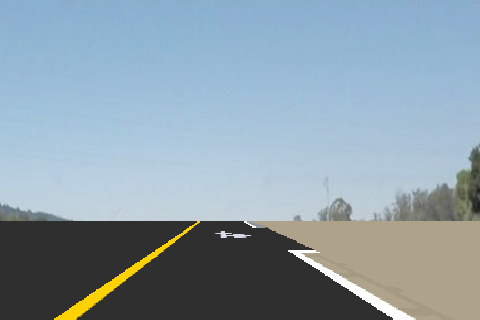

0 1196


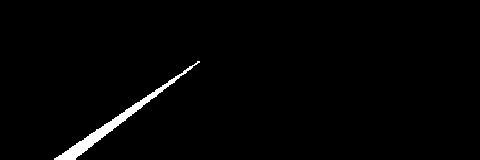

1 1145


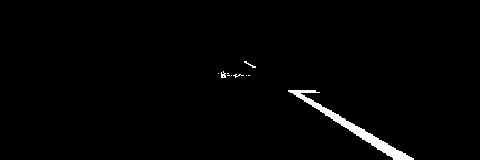

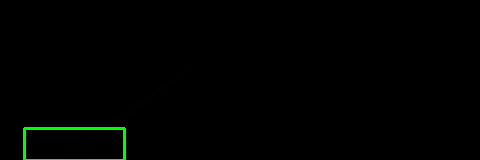

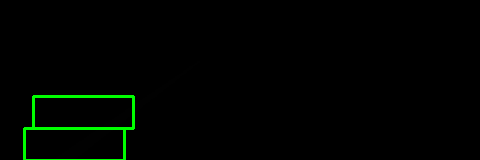

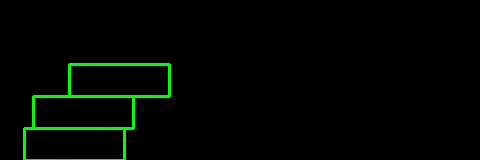

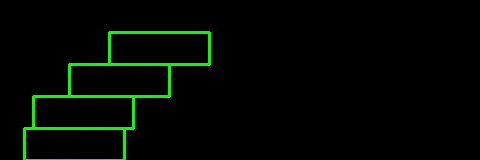

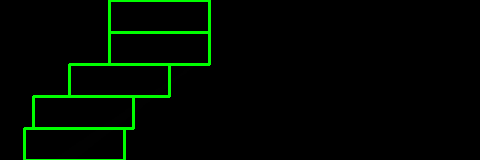

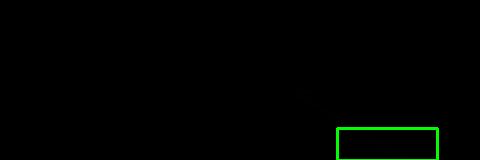

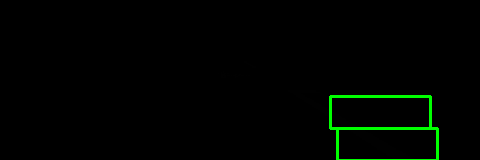

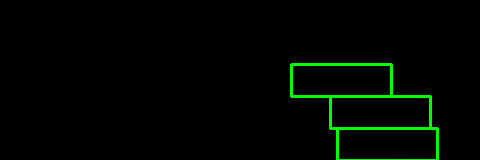

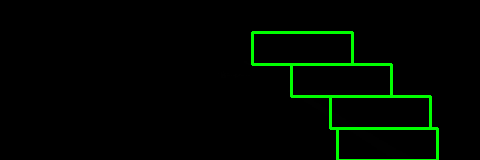

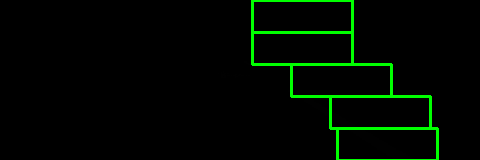

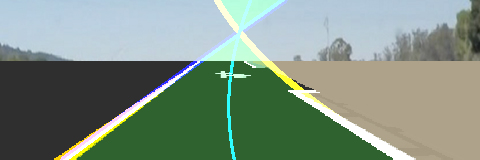

In [35]:
lane_node = DetectLane()
lane_node.hue = [[0, 50], [0, 255]]
lane_node.saturation = [[100, 255], [0, 100]]
lane_node.lightness = [[230, 255], [230, 255]]        

img = cv2.imread("map2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
camera.show_image(img)
lane = lane_node.find_lane(img[160:])
# control_node.follow_lane(lane)

# 실제 데이터
해당 방식은 프린터의 영향에 따라 결과의 오차가 큽니다. 매 프레임 결과에 따라 값이 보정되는 로직이 추가되었지만, 분명히 한계가 보이는 모습입니다.

In [5]:
from zumi.util.camera import Camera
camera = Camera(image_w=WIDTH, image_h=HEIGHT, framerate=10)

In [6]:
camera.start_camera()

Starting PiCamera


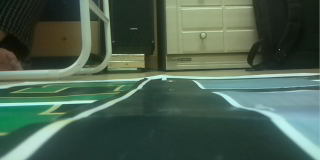

0 944


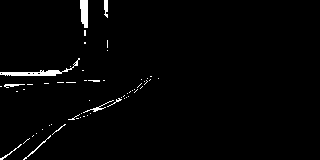

1 2507


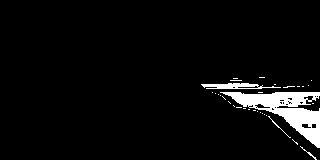

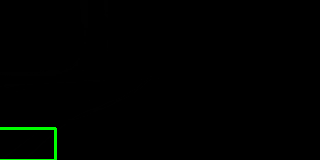

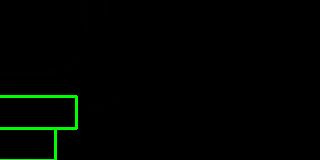

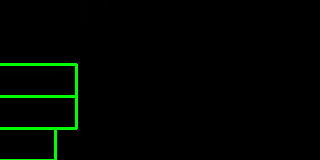

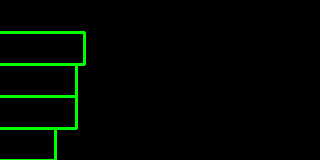

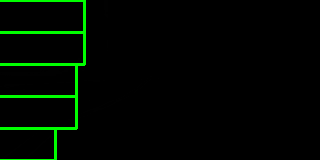

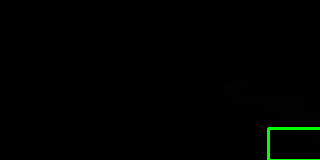

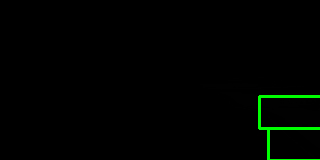

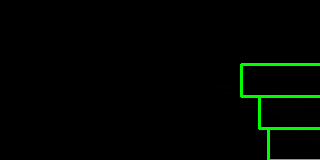

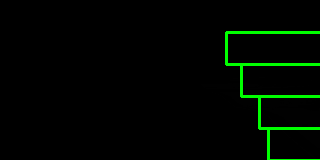

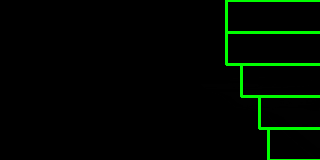

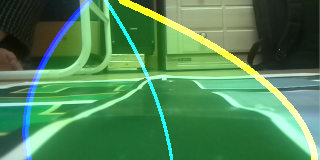

In [10]:
frame = camera.capture()
camera.show_image(frame)

lane_node = DetectLane()
lane_node.hue = [[60, 130], [80, 130]]
lane_node.saturation = [[23, 51], [60, 90]]
lane_node.lightness = [[150, 204], [160, 220]]

lane = lane_node.find_lane(frame)
# control_node.follow_lane(lane)

In [103]:
camera.close()

Closing PiCamera
